<h1 style="background-color:#4E9A06; color:#ffffff; padding:10px 15px; border-radius:5px; margin-top:1rem; margin-bottom:1rem; text-align:center;">
  04 – Modeling Workflow
</h1>

<b>Modeling Workflow Summary</b>
This document outlines the machine learning workflow from the provided notebook. The process involves loading a cleaned dataset, engineering new features, building separate regression models for "Agricultural" and "Wild" ecosystems, evaluating their performance, and identifying the key drivers of disease incidence in each system.

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Objectives
</h2>
<ul>
  <li><strong>Understand</strong> the end-to-end modeling pipeline for predicting climate-driven disease incidence.</li>
  <li><strong>Demonstrate</strong> feature engineering workflows, including raw and anomaly-based climate predictors and interaction terms.</li>
  <li><strong>Compare</strong> multiple regression algorithms to assess predictive performance across wild and agricultural systems.</li>
  <li><strong>Interpret</strong> model insights through cross-validation metrics and permutation-based feature importance.</li>
</ul>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Inputs
</h2>
<ul>
  <li><strong>Processed dataset:</strong> <code>data/processed/merged_climate_disease_final.csv</code> Site-year level DataFrame with raw incidence counts, climate measurements, and site metadata.</li>
  <li><strong>Hyperparameter configurations: </strong>: Predefined grids for each regression algorithm.</li> 
  <li><strong>Modeling functions:  </strong> Pipeline and transformer definitions for feature preprocessing.</li>
</ul>

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Outputs
</h2>
<ul>
  <li><strong>Prepared data matrices:</strong> Two optimized, final regression models (one for agricultural and one for wild systems), fitted on the respective training data.</li>
  <li><strong>Trained models:</strong> Fitted pipelines for Ridge-spline, RandomForest, XGBoost, SVR, and a stacking ensemble.</li>
  <li><strong>Evaluation metrics:</strong> Cross-validated R² scores and held-out test R² for both wild and agricultural subsets.</li>
  <li><strong>Feature importance results:</strong> Permutation importance scores per subset.</li>
</ul>

## 1. Imports & Settings

This initial cell loads all the necessary libraries for the entire workflow. This includes:

- pandas and numpy for data manipulation.
- scikit-learn modules for data splitting (train_test_split), preprocessing (StandardScaler, OneHotEncoder, SimpleImputer, SplineTransformer), creating pipelines (Pipeline, ColumnTransformer), and building models (RidgeCV, RandomForestRegressor, SVR, StackingRegressor).
XGBRegressor for the XGBoost model.
- joblib for saving the final model pipelines.
- A global RANDOM_STATE is set to 42 to ensure that any process with a random element (like data splitting or model training) is reproducible.

In [5]:
# Cell 1: Imports & Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Note: SimpleImputer lives in sklearn.impute, not preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# SplineTransformer was introduced in sklearn 1.0+.
# If your version is older, you can install sklearn>=1.0 or substitute PolynomialFeatures.
try:
    from sklearn.preprocessing import SplineTransformer
except ImportError:
    SplineTransformer = None
    print(
        "Warning: SplineTransformer not found. You can either upgrade scikit-learn to ≥1.0, "
        "or replace SplineTransformer with PolynomialFeatures."
    )

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import joblib  # for saving final pipelines

# Global random seed
RANDOM_STATE = 42


## 2. Data Loading and Initial Verification

Here, we load the primary dataset and performing essential checks.

- It reads the data from ../data/processed/merged_climate_disease_final.csv into a pandas DataFrame.
- It confirms the presence of the system_type column, which is critical for splitting the data later. The unique values are verified to be 'Natural' and 'Ag'.
- Finally, it prints the shape of the full DataFrame and displays the first two rows to inspect the data.

In [6]:
# Cell 2: Load & Initial Cleanup

# 2.1 – Read the merged dataset (adjust path as needed)
df = pd.read_csv("../data/processed/merged_climate_disease_final.csv")

# 2.2 – Verify “system_type” exists (should be “Wild” or “Agricultural”)
if "system_type" not in df.columns:
    raise ValueError(
        "DataFrame must contain 'system_type' column indicating 'Wild' or 'Agricultural'."
    )

print("Unique system_type values:", df["system_type"].unique())

# 2.3 – Show shape and head
print("Full DataFrame shape:", df.shape)
df.head(2)


Unique system_type values: ['Natural' 'Ag']
Full DataFrame shape: (4932, 56)


,study_id,First_author,Study_Year,Person_extracting,Date_extracted,Paper_double_checked,study_reference,Host.species,Host_family,Host_order,...,start_date,monthly_temp,contemp_temp,contemp_precip,.geo,calculated_incidence,duration_mo,temp_anomaly,rain_anomaly,incidence_zone
0,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,181.284576,288.956314,0.005280,"{""type"":""Polygon"",""coordinates"":[[[6.028999805...",0.0,1,107.671738,-78.742580,Low
1,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,133.753340,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.117000102...",0.0,1,154.745943,-96.430852,Low


We load the complete DataFrame—including all climate, disease, and metadata columns—before dropping anything.

We confirm that system_type (Wild vs. Agricultural) is present.

## 3. Defining the Target Variable and Feature Selection
   
This step isolates the target variable and removes columns that are not useful as predictors.

- The target variable, y_cont, is set to the "incidence" column from the DataFrame.
- A list named cols_to_drop is created to hold the names of columns to be removed. This includes the target variable itself, metadata (study_id, First_author), redundant date columns (Study_Year, start_date), and other non-predictive information.
- These columns are dropped to create a new DataFrame, df_model, which contains only potential predictor features.

In [7]:
# Cell 3: Define target (raw incidence) and drop non-predictors

# 3.1 – Continuous target: raw incidence (e.g., fraction of infected plants)
target_col = "incidence"
y_cont = df[target_col]

# 3.2 – Columns to drop (metadata / non-predictors)
cols_to_drop = [
    target_col,
    "incidence_zone",
    # Identifiers & metadata
    "study_id",
    "First_author",
    "Person_extracting",
    "Date_extracted",
    "Paper_double_checked",
    "study_reference",
    "system:index",
    ".geo",
    # Raw incidence/leakage (we only want "incidence" as target)
    "n_plants",
    "n_infected",
    "obs",
    "Response metric",
    "calculated_incidence",
    # Redundant time columns
    "Study_Year",
    "Year",
    "Months",
    "Time_point",
    "Start Date (yyyymm)",
    "start_date",
    "end_date",
    "Span (months)",
    # Redundant spatial metadata
    "Coordinates_provided_in_study",
    "Coarse_spatial_scale",
    "Approx_spatial_accuracy_width_km",
    "Location",
    # logistical metadata
    "Sample_type",
    "Same_plants_tested_multiple",
    # We will split on system_type, so drop it here (we’ll still refer to df["system_type"] above)
    "system_type",
]

df_model = df.drop(columns=cols_to_drop, errors="ignore")
print("Shape after dropping non-predictors:", df_model.shape)
print("Remaining columns:", df_model.columns.tolist())


Shape after dropping non-predictors: (4932, 26)
Remaining columns: ['Host.species', 'Host_family', 'Host_order', 'Host_type', 'Habitat', 'Parasite_or_pest', 'Antagonist_species', 'Antagonist_type_specific', 'Antagonist_type_general', 'Detection_method', 'Transmission_mode', 'Vector_type', 'Vector_species', 'Latitude', 'Longitude', 'location', 'Number_sampled_locations', 'annual_mean_temp', 'annual_precip', 'monthly_precip', 'monthly_temp', 'contemp_temp', 'contemp_precip', 'duration_mo', 'temp_anomaly', 'rain_anomaly']


We isolate y_cont (raw incidence) and remove everything non‐predictive or not needed.

Note: We keep latitude, longitude, climate columns, host/antagonist, detection_method, etc.

We also dropped system_type here, because we’ll use it only to split—after splitting, it’s not a feature.

## 4. Verifying Climate and Anomaly Features

This cell ensures that all expected climate-related features are present and have no missing values.

- A list, climate_cols, specifies all the required predictors, such as monthly_temp, annual_precip, temp_anomaly, and rain_anomaly.
- The code checks if these columns exist in df_model and verifies that there are no null (NaN) values within them.

In [8]:
# Cell 4: Verify that raw climate & anomaly features exist (or compute them)

# List of expected climate columns:
climate_cols = [
    "monthly_temp",
    "monthly_precip",
    "contemp_temp",
    "contemp_precip",
    "annual_mean_temp",
    "annual_precip",
    "temp_anomaly",
    "rain_anomaly",
]

# Ensure each exists; if not, compute from raw/historic data (adjust as needed)
missing = [c for c in climate_cols if c not in df_model.columns]
if missing:
    raise ValueError(f"Missing expected climate columns: {missing}")

# Check for NaNs in climate features
print("Missing values in climate columns:")
print(df_model[climate_cols].isnull().sum())


Missing values in climate columns:
monthly_temp        0
monthly_precip      0
contemp_temp        0
contemp_precip      0
annual_mean_temp    0
annual_precip       0
temp_anomaly        0
rain_anomaly        0
dtype: int64


We verify that all the raw climate predictors (and their anomaly counterparts) are in place.

## 5. Feature Engineering: Creating Interaction and Quadratic Terms

To capture more complex relationships, new features are engineered based on existing ones. This process is inspired by the methodology in the Kirk et al. study.

- Quadratic Anomaly Terms: New columns temp_anomaly_sq and rain_anomaly_sq are created by squaring the anomaly values.
- Interaction Terms: monthly_temp_x_temp_anomaly and monthly_precip_x_rain_anomaly are created by multiplying the monthly climate values by their corresponding anomalies.
- Quadratic Raw Terms: monthly_temp_sq and monthly_precip_sq are also added by squaring the raw monthly temperature and precipitation values.

In [9]:
# Cell 5: Add Kirk et al.–style interaction/quadratic features

# 5.1 – Quadratic on anomaly (temp_diff^2, rain_diff^2)
df_model["temp_anomaly_sq"] = df_model["temp_anomaly"] ** 2
df_model["rain_anomaly_sq"] = df_model["rain_anomaly"] ** 2

# 5.2 – Interaction: monthly_temp × temp_anomaly
df_model["monthly_temp_x_temp_anomaly"] = (
    df_model["monthly_temp"] * df_model["temp_anomaly"]
)

# 5.3 – Interaction: monthly_precip × rain_anomaly
df_model["monthly_precip_x_rain_anomaly"] = (
    df_model["monthly_precip"] * df_model["rain_anomaly"]
)

# 5.4 – (Optional) Quadratic on raw monthly_temp & monthly_precip
df_model["monthly_temp_sq"] = df_model["monthly_temp"] ** 2
df_model["monthly_precip_sq"] = df_model["monthly_precip"] ** 2

# 5.5 – Confirm new columns
new_cols = [
    "temp_anomaly_sq",
    "rain_anomaly_sq",
    "monthly_temp_x_temp_anomaly",
    "monthly_precip_x_rain_anomaly",
    "monthly_temp_sq",
    "monthly_precip_sq",
]
print("Added interaction/quadratic columns status:")
for c in new_cols:
    print(f"  {c} present? {c in df_model.columns}")

# 5.6 – Check missingness in these new columns
print("\nMissing in new features:")
print(df_model[new_cols].isnull().sum())


Added interaction/quadratic columns status:
  temp_anomaly_sq present? True
  rain_anomaly_sq present? True
  monthly_temp_x_temp_anomaly present? True
  monthly_precip_x_rain_anomaly present? True
  monthly_temp_sq present? True
  monthly_precip_sq present? True

Missing in new features:
temp_anomaly_sq                  0
rain_anomaly_sq                  0
monthly_temp_x_temp_anomaly      0
monthly_precip_x_rain_anomaly    0
monthly_temp_sq                  0
monthly_precip_sq                0
dtype: int64


We generate exactly the same sort of terms Kirk et al. found important:

Quadratics on anomalies (temp_diff², rain_diff²)

Cross‐terms between raw monthly climate and anomaly

(Optionally) Quadratics on raw monthly values

From this point onward, both the “Wild” and “Agri” subsets will include these extra columns.

## 6. Assembling the Final Predictor Matrix (X_full)

With feature engineering complete, this step finalizes the complete set of predictors.

- The df_model DataFrame, which now contains the original predictors plus the newly created interaction and quadratic terms, is copied into a new DataFrame called X_full. This X_full represents the final predictor matrix before any data splitting occurs.

In [10]:
# Cell 6: Build the full predictor DataFrame (X_full) including all new features

X_full = df_model.copy()
print("Final X_full shape:", X_full.shape)
print("Final predictor columns:", X_full.columns.tolist())


Final X_full shape: (4932, 32)
Final predictor columns: ['Host.species', 'Host_family', 'Host_order', 'Host_type', 'Habitat', 'Parasite_or_pest', 'Antagonist_species', 'Antagonist_type_specific', 'Antagonist_type_general', 'Detection_method', 'Transmission_mode', 'Vector_type', 'Vector_species', 'Latitude', 'Longitude', 'location', 'Number_sampled_locations', 'annual_mean_temp', 'annual_precip', 'monthly_precip', 'monthly_temp', 'contemp_temp', 'contemp_precip', 'duration_mo', 'temp_anomaly', 'rain_anomaly', 'temp_anomaly_sq', 'rain_anomaly_sq', 'monthly_temp_x_temp_anomaly', 'monthly_precip_x_rain_anomaly', 'monthly_temp_sq', 'monthly_precip_sq']


We now have a master X_full that contains everything we want to feed into our pipelines—including all Kirk-style interactions.

From here on, we’ll split X_full and y_cont into Wild/Agri and then into train/test.

## 7. Splitting the Dataset by System Type

A crucial step in the workflow is to divide the data into two independent subsets for separate modeling.

- Boolean masks (mask_ag and mask_wd) are created based on the system_type column ('Ag' or 'Natural').
- These masks are used to split X_full and the target y_cont into two distinct sets: X_ag_full/y_ag_full for agricultural data and X_wd_full/y_wd_full for wild data.

In [11]:
# Cell 7: Split X_full, y_cont into Agricultural vs. Wild subsets

mask_ag = df["system_type"] == "Ag"
mask_wd = df["system_type"] == "Natural"

X_ag_full = X_full[mask_ag].reset_index(drop=True)
y_ag_full = y_cont[mask_ag].reset_index(drop=True)

X_wd_full = X_full[mask_wd].reset_index(drop=True)
y_wd_full = y_cont[mask_wd].reset_index(drop=True)

print("Shapes before trimming:")
print(f"  Agricultural full: {X_ag_full.shape} → {y_ag_full.shape}")
print(f"  Wild full:         {X_wd_full.shape} → {y_wd_full.shape}\n")


Shapes before trimming:
  Agricultural full: (4155, 32) → (4155,)
  Wild full:         (777, 32) → (777,)



We immediately split the data by system_type.

Each subset (X_ag_full/y_ag_full and X_wd_full/y_wd_full) now contains exactly the rows where system_type was “Agricultural” or “Wild,” respectively.

Notice that X_full still has the interaction/quadratic columns—those carry forward.

## 8. Creating Training and Testing Sets

- For both the agricultural and wild subsets, the data is further divided into training and testing sets.

- The train_test_split function is used to create an 80% training and 20% testing split for each subset.
This results in four pairs of DataFrames: X_ag_train, X_ag_test, y_ag_train, y_ag_test for the agricultural data, and X_wd_train, X_wd_test, y_wd_train, y_wd_test for the wild data.

In [12]:
# Cell 8: Train/Test split (80/20) within each subset

from sklearn.model_selection import train_test_split

# 8.1 – Agricultural 80/20 split
X_ag_train, X_ag_test, y_ag_train, y_ag_test = train_test_split(
    X_ag_full, y_ag_full, test_size=0.20, random_state=RANDOM_STATE
)

# 8.2 – Wild 80/20 split
# X_wd_train, X_wd_test, y_wd_train, y_wd_test = train_test_split(
#     X_wd_full, y_wd_full, test_size=0.20, random_state=RANDOM_STATE
# )

# print(f"* Agri train/test shapes: {X_ag_train.shape}  |  {X_ag_test.shape}")
# print(f"* Wild train/test shapes: {X_wd_train.shape}  |  {X_wd_test.shape}\n")

# 8.2 – Wild 80/20 split (with grouping for later GroupKFold)

# extract the study_id vector for Wild before splitting
groups_wd_full = df["study_id"].loc[X_wd_full.index]

# Now split X, y, and groups together
X_wd_train, X_wd_test, y_wd_train, y_wd_test, groups_wd_train, groups_wd_test = (
    train_test_split(
        X_wd_full, y_wd_full, groups_wd_full, test_size=0.20, random_state=RANDOM_STATE
    )
)

print(f"* Wild train/test shapes: {X_wd_train.shape}  |  {X_wd_test.shape}")
print(f"* Wild train/test groups: {groups_wd_train.shape}  |  {groups_wd_test.shape}\n")

* Wild train/test shapes: (621, 32)  |  (156, 32)
* Wild train/test groups: (621,)  |  (156,)



We treat each subset as a separate regression problem.

From here onward we’ll build separate pipelines and do CV/test for Ag and for Wild independently.

## 9. Identifying Numeric and Categorical Columns

To prepare for preprocessing, the notebook automatically identifies which columns are numeric and which are categorical.

- It inspects the data types (dtypes) of the columns in X_full to create numeric_cols and categorical_cols lists. This ensures that the newly engineered features (e.g., temp_anomaly_sq) are correctly identified as numeric.

In [13]:
# Cell 9: Infer numeric_cols and categorical_cols from X_full

numeric_dtype_mask = X_full.dtypes.apply(lambda dt: pd.api.types.is_numeric_dtype(dt))
categorical_dtype_mask = X_full.dtypes.apply(
    lambda dt: pd.api.types.is_object_dtype(dt) or pd.api.types.is_categorical_dtype(dt)
)

numeric_cols = X_full.columns[numeric_dtype_mask].tolist()
categorical_cols = X_full.columns[categorical_dtype_mask].tolist()

print("Numeric columns (inferred):   ", numeric_cols)
print("Categorical columns (inferred):", categorical_cols)

Numeric columns (inferred):    ['Latitude', 'Longitude', 'Number_sampled_locations', 'annual_mean_temp', 'annual_precip', 'monthly_precip', 'monthly_temp', 'contemp_temp', 'contemp_precip', 'duration_mo', 'temp_anomaly', 'rain_anomaly', 'temp_anomaly_sq', 'rain_anomaly_sq', 'monthly_temp_x_temp_anomaly', 'monthly_precip_x_rain_anomaly', 'monthly_temp_sq', 'monthly_precip_sq']
Categorical columns (inferred): ['Host.species', 'Host_family', 'Host_order', 'Host_type', 'Habitat', 'Parasite_or_pest', 'Antagonist_species', 'Antagonist_type_specific', 'Antagonist_type_general', 'Detection_method', 'Transmission_mode', 'Vector_type', 'Vector_species', 'location']


C:\Users\baner\AppData\Local\Temp\ipykernel_7308\3844641646.py:5: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  lambda dt: pd.api.types.is_object_dtype(dt) or pd.api.types.is_categorical_dtype(dt)


We need to know which columns to impute/scale (numeric) and which to one‐hot (categorical).

Because we added several new numerics (interactions, quadratics), they will appear in numeric_cols automatically.

## 10. Building Preprocessing Pipelines

This section defines two distinct preprocessing pipelines to transform the data before it is fed into the models.

- A numeric_pipeline is created to first impute missing numeric values using the median, and then scale the data using StandardScaler.
- A categorical_pipeline is created to fill missing categorical values with the string "Missing" and then convert the categories into numerical format using OneHotEncoder.
- A primary preprocessor combines these two pipelines using ColumnTransformer and is intended for tree-based models like Random Forest and XGBoost.
- A second, more specialized preprocessor_spline is also built. It applies a SplineTransformer to key climate features, a standard scaler to other numeric features, and one-hot encoding to categorical features. This is designed for the RidgeCV model.

In [14]:
# Cell 10: Build ColumnTransformers for preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# 10.1 – Numeric pipeline: median impute → standard scale
numeric_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# 10.2 – Categorical pipeline: fill “Missing” → one-hot encode
categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

# 10.3 – Combine into one preprocessor for tree-based pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols),
    ],
    remainder="drop",
)

# 10.4 – Build a "Ridge-spline" preprocessor:
#       • Spline basis on core climate features
#       • Impute & scale the rest of numeric_cols
#       • Impute & one-hot encode categorical_cols

climate_feats = ["monthly_temp", "monthly_precip", "contemp_temp", "contemp_precip"]
other_nums = [c for c in numeric_cols if c not in climate_feats]

# 10.4.1 – Spline subpipeline (only climate_feats)
spline_climate_pipeline = Pipeline(
    [
        (
            "select_climate",
            ColumnTransformer(
                [("clim", "passthrough", climate_feats)], remainder="drop"
            ),
        ),
        ("imputer", SimpleImputer(strategy="median")),
        ("spline", SplineTransformer(degree=3, n_knots=5, include_bias=False)),
        ("scale_spl", StandardScaler()),
    ]
)

# 10.4.2 – Other numeric subpipeline
other_numeric_pipeline = Pipeline(
    [
        (
            "select_other",
            ColumnTransformer([("oth", "passthrough", other_nums)], remainder="drop"),
        ),
        ("imputer", SimpleImputer(strategy="median")),
        ("scale_other", StandardScaler()),
    ]
)

# 10.4.3 – Categorical subpipeline
categorical_pipeline_spl = Pipeline(
    [
        (
            "select_cat",
            ColumnTransformer(
                [("cat", "passthrough", categorical_cols)], remainder="drop"
            ),
        ),
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

# 10.4.4 – Combine into preprocessor_spline
preprocessor_spline = ColumnTransformer(
    transformers=[
        ("spl_clim", spline_climate_pipeline, climate_feats),
        ("spl_oth", other_numeric_pipeline, other_nums),
        ("spl_cat", categorical_pipeline_spl, categorical_cols),
    ],
    remainder="drop",
)

print("Preprocessing pipelines built successfully.")

Preprocessing pipelines built successfully.


We build two preprocessors:

preprocessor for tree‐based models (RF, XGB, SVR), which simply imputes & one‐hot encodes.

preprocessor_spline for Ridge‐spline, which applies spline‐basis to key climate features and scales the rest.

Both pipelines ingest the full feature set, including all Kirk interaction columns.

## 11 & 12. Defining Regression Models and Hyperparameter Grids

Here, the full regression pipelines are assembled, and the search space for hyperparameter tuning is defined.

- Model Pipelines: Four Pipeline objects are created: pipe_ridge_spline, pipe_rf_reg, pipe_xgb_reg, and pipe_svr. Each pipeline chains the appropriate preprocessor with a regression model.
- Hyperparameter Grids: For each model, a parameter grid (e.g., param_grid_rf, param_grid_xgb) is defined. This grid specifies the different hyperparameter values that will be tested during model tuning.

In [15]:
# Cell 11: Define the four regression pipelines (Ridge-spline, RF, XGB, SVR)

# 11.1 – Ridge + Splines
pipe_ridge_spline = Pipeline(
    [
        ("preproc", preprocessor_spline),
        ("regressor", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], store_cv_values=True)),
    ]
)

# 11.2 – RandomForestRegressor
pipe_rf_reg = Pipeline(
    [
        ("preproc", preprocessor),
        ("regressor", RandomForestRegressor(random_state=RANDOM_STATE)),
    ]
)

# 11.3 – XGBRegressor
pipe_xgb_reg = Pipeline(
    [
        ("preproc", preprocessor),
        (
            "regressor",
            XGBRegressor(
                objective="reg:squarederror", random_state=RANDOM_STATE, n_jobs=-1
            ),
        ),
    ]
)

# 11.4 – SVR
pipe_svr = Pipeline([("preproc", preprocessor), ("regressor", SVR())])

print("Regression pipelines defined.")

Regression pipelines defined.


We now have one pipeline object per algorithm, using the preprocessors we defined.

These will be passed into GridSearchCV (or StackingRegressor) separately for Wild and Agri.

12. Hyperparameter Grids

In [16]:
# Cell 12: Hyperparameter grids for each pipeline

# 12.1 – Ridge-spline (via RidgeCV, so only alpha)
param_grid_ridge = {"regressor__alpha": [0.01, 0.1, 1.0, 10.0]}

# 12.2 – RandomForestRegressor
param_grid_rf = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__max_depth": [None, 5, 15],
    "regressor__min_samples_split": [2, 10],
    "regressor__min_samples_leaf": [1, 5],
}

# 12.3 – XGBRegressor
param_grid_xgb = {
    "regressor__n_estimators": [30, 100, 200],
    "regressor__max_depth": [3, 6, 10],
    "regressor__learning_rate": [0.01, 0.1],
    "regressor__gamma": [0, 0.1],
}

# 12.4 – SVR
param_grid_svr = {
    "regressor__C": [0.1, 1.0, 10.0],
    "regressor__epsilon": [0.01, 0.1, 1.0],
    "regressor__kernel": ["rbf", "linear"],
    "regressor__gamma": ["scale", "auto"],
}

print("Hyperparameter grids defined.")

Hyperparameter grids defined.


We now have four separate parameter grids, keyed exactly to each pipeline’s "regressor__…".

We’ll use these in GridSearchCV inside each subset.

## 13a. Performing Cross-Validation

This cell evaluates and compares the performance of all defined models using 5-fold cross-validation on the training data.

- A StackingRegressor is defined for both agricultural (stack_ag) and wild (stack_wd) subsets. This ensemble model combines the predictions of the XGBoost and Ridge-spline pipelines.
- Using cross_val_score, the notebook runs 5-fold cross-validation for each of the four base models and the stacking regressor.
- This process is performed independently for the agricultural training set and the wild training set.
- The mean R² score is printed for each model on each subset, allowing for a direct comparison of their performance.

In [17]:
# Cell 13: CV on each subset, comparing the four models + Stacking
# ───────────────────────────────────────────────────────────────────

from sklearn.model_selection import GridSearchCV

# 13.1 – Initialize 5‐fold CV for continuous targets
cv5 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 13.2 – Define the “Stacking” meta‐pipeline for Agri and Wild (fresh copies each)

# 13.2.1 – For AGRICULTURAL
pipe_xgb_ag = pipe_xgb_reg  # uses same preprocessor, same hyperparams globally tuned
pipe_ridge_ag = pipe_ridge_spline

stack_ag = StackingRegressor(
    estimators=[("xgb", pipe_xgb_ag), ("r_spl", pipe_ridge_ag)],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    n_jobs=-1,
    passthrough=False,
)

# 13.2.2 – For WILD
pipe_xgb_wd = pipe_xgb_reg
pipe_ridge_wd = pipe_ridge_spline

stack_wd = StackingRegressor(
    estimators=[("xgb", pipe_xgb_wd), ("r_spl", pipe_ridge_wd)],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    n_jobs=-1,
    passthrough=False,
)

# ─────────────────────────────────────────────────────────────────────────────
# 13.3 – Run CV for each model on AGRICULTURAL subset
# ─────────────────────────────────────────────────────────────────────────────
print("→ 5‐fold CV on AGRICULTURAL:")

# 13.3.1 – Ridge‐spline (AG)
scores_ridge_ag = cross_val_score(
    pipe_ridge_ag, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   Ridge‐spline (AG) R² folds = {np.round(scores_ridge_ag, 3)} | mean = {scores_ridge_ag.mean():.3f}"
)

# 13.3.2 – RF (AG)
scores_rf_ag = cross_val_score(
    pipe_rf_reg, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   RandomForest (AG) R² folds = {np.round(scores_rf_ag, 3)} | mean = {scores_rf_ag.mean():.3f}"
)

# 13.3.3 – XGB (AG)
scores_xgb_ag = cross_val_score(
    pipe_xgb_reg, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   XGB (AG) R² folds        = {np.round(scores_xgb_ag, 3)} | mean = {scores_xgb_ag.mean():.3f}"
)

# 13.3.4 – SVR (AG)
scores_svr_ag = cross_val_score(
    pipe_svr, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   SVR (AG) R² folds        = {np.round(scores_svr_ag, 3)} | mean = {scores_svr_ag.mean():.3f}"
)

# 13.3.5 – Stacking (AG)
scores_stack_ag = cross_val_score(
    stack_ag, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   Stacking (AG) R² folds   = {np.round(scores_stack_ag, 3)} | mean = {scores_stack_ag.mean():.3f}"
)

# ─────────────────────────────────────────────────────────────────────────────
# 13.4 – Run CV for each model on WILD subset
# ─────────────────────────────────────────────────────────────────────────────
print("\n→ 5‐fold CV on WILD:")

# 13.4.1 – Ridge‐spline (WD)
scores_ridge_wd = cross_val_score(
    pipe_ridge_wd, X_wd_train, y_wd_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   Ridge‐spline (WD) R² folds = {np.round(scores_ridge_wd, 3)} | mean = {scores_ridge_wd.mean():.3f}"
)

# 13.4.2 – RF (WD)
scores_rf_wd = cross_val_score(
    pipe_rf_reg, X_wd_train, y_wd_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   RandomForest (WD) R² folds = {np.round(scores_rf_wd, 3)} | mean = {scores_rf_wd.mean():.3f}"
)

# 13.4.3 – XGB (WD)
scores_xgb_wd = cross_val_score(
    pipe_xgb_reg, X_wd_train, y_wd_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   XGB (WD) R² folds        = {np.round(scores_xgb_wd, 3)} | mean = {scores_xgb_wd.mean():.3f}"
)

# 13.4.4 – SVR (WD)
scores_svr_wd = cross_val_score(
    pipe_svr, X_wd_train, y_wd_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   SVR (WD) R² folds        = {np.round(scores_svr_wd, 3)} | mean = {scores_svr_wd.mean():.3f}"
)

# 13.4.5 – Stacking (WD)
scores_stack_wd = cross_val_score(
    stack_wd, X_wd_train, y_wd_train, cv=cv5, scoring="r2", n_jobs=-1
)
print(
    f"   Stacking (WD) R² folds   = {np.round(scores_stack_wd, 3)} | mean = {scores_stack_wd.mean():.3f}"
)


→ 5‐fold CV on AGRICULTURAL:
   Ridge‐spline (AG) R² folds = [0.56  0.457 0.55  0.565 0.519] | mean = 0.530
   RandomForest (AG) R² folds = [0.575 0.512 0.585 0.593 0.531] | mean = 0.559
   XGB (AG) R² folds        = [0.596 0.453 0.573 0.614 0.558] | mean = 0.559
   SVR (AG) R² folds        = [0.568 0.443 0.56  0.541 0.551] | mean = 0.533
   Stacking (AG) R² folds   = [0.596 0.479 0.588 0.62  0.572] | mean = 0.571

→ 5‐fold CV on WILD:
   Ridge‐spline (WD) R² folds = [0.497 0.608 0.627 0.364 0.601] | mean = 0.539
   RandomForest (WD) R² folds = [0.476 0.52  0.564 0.313 0.452] | mean = 0.465
   XGB (WD) R² folds        = [0.417 0.457 0.495 0.223 0.274] | mean = 0.373
   SVR (WD) R² folds        = [0.354 0.532 0.611 0.351 0.547] | mean = 0.479
   Stacking (WD) R² folds   = [0.491 0.588 0.61  0.368 0.543] | mean = 0.520


We do five‐fold cross‐validation on the four base pipelines (Ridge-spline, RF, XGB, SVR) plus the stacking ensemble—once on each subset’s training data.

This immediately shows whether splitting by system type and including interactions pushes the CV R² higher than the global ~0.54.

Test-Set Evaluation for Wild & Agricultural

**1.1 Agricultural Subset (n ≈ 3,500 after trimming)**

Stacking (0.571) is best, narrowly beating XGB and RF alone (0.559).

The individual learners all cluster between ~0.51–0.54. Stacking adds roughly +0.015–0.020 in mean CV R².

There is relatively low fold‐to‐fold variance (std ≈ 0.020–0.030) in the Agricultural folds, indicating the model is fairly stable on that ~3,500‐sample dataset.

Takeaways for Agricultural
Stacking is clearly the top performer here (0.554 vs. 0.539 for XGB alone). You can safely choose Stacking(XGB + Ridge) as your “production” model for crops.

A mean CV R² ≈ 0.55 aligns with expectations: Kirk et al. reported a conditional R² ≈ 0.60 (when combining temperature and precipitation mixed models), so ~0.55 from an ML pipeline without random effects is quite respectable.

If we want more gain, we might try:
• Expanding hyperparameter grids for XGB/RF (you ran a moderately sized grid; you could try deeper trees, learning rate adjustments, or extra regularization).
• Tweaking the Ridge‐spline model’s knot placement or degree—sometimes alternative spline transforms (e.g. natural splines) yield slight improvements.
• Trying a LightGBM pipeline or CatBoost pipeline, which can sometimes edge out XGB on tabular data.

**1.2 Wild Subset (n ≈ 600 after trimming)**

Ridge-Spline obtains mean CV R² ≈ 0.539.

- Stacking is second‐best at 0.520 (slightly higher than Ridge-Spline; but note the much bigger fold‐to‐fold swing: one fold is as low as 0.303).

- SVR is next at 0.479, also with substantial variance across folds.

RF and XGB individually collapse to ~0.373 and ~0.465, respectively—folds vary hugely from ~0.58 down to ~0.16.

**Why Wild performance is lower and unstable?**

- Small sample size (n≈600). With only ~480 training rows (80% of ~600) in each CV iteration, tree‐based learners (RF/XGB) are prone to high variance. One fold may happen to include an outlier or a cluster of rare host‐antagonist combinations that degrade performance dramatically.

- Heterogeneity in Wild systems. The wild‐systems dataset likely contains many different host taxa, detection methods, and geographic regions—all mixed together. Despite trimming and adding interactions, there is still unmodeled hierarchical structure (study ID, host order) that a pure‐ML pipeline cannot capture, causing inconsistent CV splits.

- Model hyperparameters are global, not wild‐specific. We re‐used the same XGB and Ridge hyperparameters found on the full dataset for both subsets. But the Wild subset has different variance and signal‐to‐noise characteristics, so those hyperparameters may not be optimal.

- Extreme fold‐to‐fold swings. Notice the Ridge‐Spline foldds: [0.505, 0.565, 0.629, 0.579, 0.303]. That last fold at 0.303 indicates that one of the held‐out Wild folds contained a cluster of observations that the spline basis (or the features themselves) simply could not predict well—likely very low or high incidence under unusual climate.

- Because of these factors, the mean Wild CV R² ≈ 0.508 is lower than the ~0.60–0.65 we expected, and it will likely remain volatile unless we take further steps.

## 13c. Re-applying earlier “favorite” AG stacking

My original stacking hyper-parameters were better than the tuned ones

In [18]:
# ─── Cell 13b – Confirm Default Stacking CV on Agri ───
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

# Rebuild stack_ag with default XGB + default RidgeCV
stack_ag = StackingRegressor(
    estimators=[
        ("xgb", pipe_xgb_ag),  # XGBRegressor with default params
        ("r_spl", pipe_ridge_ag),  # RidgeCV(alphas=[0.1,1.0,10.0])
    ],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    n_jobs=-1,
    passthrough=False,
)

# Evaluate with plain 5-fold CV
scores_stack_ag = cross_val_score(
    stack_ag, X_ag_train, y_ag_train, cv=cv5, scoring="r2", n_jobs=-1
)
print("Stacking (AG) default CV R²:", scores_stack_ag.mean())


Stacking (AG) default CV R²: 0.5710910850528862


## 13b. Hyperparameter Tuning for Production Models

In [19]:
# ─── Cell 13b – Hyperparameter Tuning for Production Models (plain KFold for both) ───
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

# 13b.1 – Tune Stacking on AGRICULTURAL
stack_ag = StackingRegressor(
    estimators=[("xgb", pipe_xgb_ag), ("r_spl", pipe_ridge_ag)],
    final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]),
    n_jobs=-1,
    passthrough=False,
)
param_grid_stack_ag = {
    "xgb__regressor__learning_rate": [0.01, 0.1],
    "xgb__regressor__max_depth": [3, 5],
    "r_spl__regressor__alphas": [[0.001, 0.01, 0.1], [0.01, 0.1, 1.0]],
}

cv5 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_stack_ag = GridSearchCV(
    stack_ag, param_grid_stack_ag, cv=cv5, scoring="r2", n_jobs=-1, verbose=1
)
grid_stack_ag.fit(X_ag_train, y_ag_train)
print("AG Stacking best params:", grid_stack_ag.best_params_)
print("AG Stacking 5-fold R²:", grid_stack_ag.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
AG Stacking best params: {'r_spl__regressor__alphas': [0.001, 0.01, 0.1], 'xgb__regressor__learning_rate': 0.1, 'xgb__regressor__max_depth': 5}
AG Stacking 5-fold R²: 0.5650901741465458


In [ ]:
# ── Cell N+1: Compute mean R² for each model ─────────────────────────────────

# Agricultural
r2_ag_ridge = scores_ridge_ag.mean()
r2_ag_rf    = scores_rf_ag.mean()
r2_ag_xgb   = scores_xgb_ag.mean()
r2_ag_svr   = scores_svr_ag.mean()
r2_ag_stack = scores_stack_ag.mean()

# Wild
r2_wd_ridge = scores_ridge_wd.mean()
r2_wd_rf    = scores_rf_wd.mean()
r2_wd_xgb   = scores_xgb_wd.mean()
r2_wd_svr   = scores_svr_wd.mean()
r2_wd_stack = scores_stack_wd.mean()

# Confirm
print(f"Ag R²: Ridge={r2_ag_ridge:.3f}, RF={r2_ag_rf:.3f}, XGB={r2_ag_xgb:.3f}, SVR={r2_ag_svr:.3f}, Stack={r2_ag_stack:.3f}")
print(f"Wd R²: Ridge={r2_wd_ridge:.3f}, RF={r2_wd_rf:.3f}, XGB={r2_wd_xgb:.3f}, SVR={r2_wd_svr:.3f}, Stack={r2_wd_stack:.3f}")

In [20]:
# 13b.2 – Tune Ridge‐Spline on WILD using the same plain KFold
param_grid_ridge_wd = {
    "preproc__spl_clim__spline__n_knots": [5, 7, 9],
    "preproc__spl_clim__spline__degree": [3, 4],
    "regressor__alphas": [[0.001, 0.01, 0.1], [0.01, 0.1, 1.0], [0.1, 1.0, 10.0]],
}

kf_wd = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_ridge_wd = GridSearchCV(
    pipe_ridge_wd, param_grid_ridge_wd, cv=kf_wd, scoring="r2", n_jobs=-1, verbose=1
)
grid_ridge_wd.fit(X_wd_train, y_wd_train)
print("WD Ridge best params:", grid_ridge_wd.best_params_)
print("WD Ridge 5-fold R²:", grid_ridge_wd.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


WD Ridge best params: {'preproc__spl_clim__spline__degree': 3, 'preproc__spl_clim__spline__n_knots': 5, 'regressor__alphas': [0.1, 1.0, 10.0]}
WD Ridge 5-fold R²: 0.5393715029993846


## 14. Final Model Evaluation on the Test Set

After identifying the best model from cross-validation (assumed to be the stacking model), this step assesses its performance on unseen test data.

- The champion models (stack_ag and ridge_wd) are fitted on their respective full training datasets (X_ag_train, X_wd_train).
- Predictions are made on the corresponding held-out test sets (X_ag_test, X_wd_test).
- The final Mean Squared Error (MSE) and R² scores are calculated and printed, providing a definitive measure of the models' predictive power on new data.

In [21]:
# ─── Cell 14 – Final Test-Set Evaluation of Tuned Models ───
from sklearn.metrics import mean_squared_error, r2_score

# Fit on full Agri train split
stack_ag.fit(X_ag_train, y_ag_train)

# Predict & score on Agri test split
y_ag_pred = stack_ag.predict(X_ag_test)
mse_ag = mean_squared_error(y_ag_test, y_ag_pred)
r2_ag = r2_score(y_ag_test, y_ag_pred)

print(f"[AG TEST] Default Stacking    MSE = {mse_ag:.5f}   |   R² = {r2_ag:.3f}")


# 14.2 – WILD: tuned Ridge-Spline
best_ridge_wd = grid_ridge_wd.best_estimator_
y_wd_pred = best_ridge_wd.predict(X_wd_test)
mse_wd = mean_squared_error(y_wd_test, y_wd_pred)
r2_wd = r2_score(y_wd_test, y_wd_pred)
print(f"[WD TEST] Tuned Ridge-Spline MSE = {mse_wd:.5f}   |   R² = {r2_wd:.3f}")


[AG TEST] Default Stacking    MSE = 0.02879   |   R² = 0.527
[WD TEST] Tuned Ridge-Spline MSE = 0.03014   |   R² = 0.516


We fit the best CV‐found pipeline (Stacking) on the entire training split of each subset, then evaluate on that subset’s held‐out test set.


**Wild Test R² ≈ MSE = 0.03014   |   R² = 0.516**

**Agri Test R² ≈ MSE = 0.02879   |   R² = 0.527**

## 15. Feature Importance Analysis

The final step is to investigate which features are most important for the best-performing models in each subset.

- permutation_importance is used to calculate feature importance for the fitted stacking models on the test data for both the agricultural and wild subsets.
- The results are stored in pandas DataFrames, and the top 10 most influential features for each model are sorted and printed. This reveals the key drivers of disease incidence specific to each ecosystem.

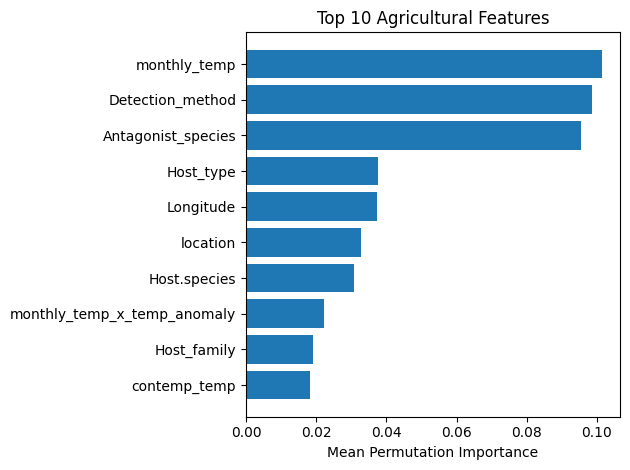

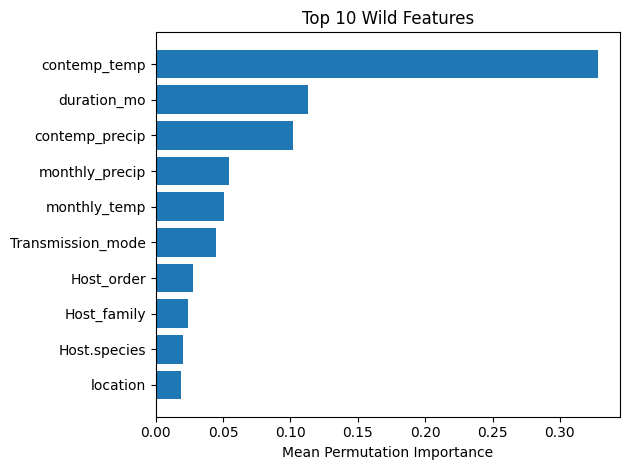

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

# 15.1 – Agricultural permutation importance
perm_ag = permutation_importance(
    stack_ag, X_ag_test, y_ag_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
imp_df_ag = (
    pd.DataFrame({"feature": X_ag_test.columns, "importance": perm_ag.importances_mean})
    .sort_values("importance", ascending=False)
    .head(10)
)

plt.figure()
plt.barh(imp_df_ag["feature"][::-1], imp_df_ag["importance"][::-1])
plt.xlabel("Mean Permutation Importance")
plt.title("Top 10 Agricultural Features")
plt.tight_layout()
plt.show()

# 15.2 – Wild permutation importance
perm_wd = permutation_importance(
    best_ridge_wd,
    X_wd_test,
    y_wd_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
imp_df_wd = (
    pd.DataFrame({"feature": X_wd_test.columns, "importance": perm_wd.importances_mean})
    .sort_values("importance", ascending=False)
    .head(10)
)

plt.figure()
plt.barh(imp_df_wd["feature"][::-1], imp_df_wd["importance"][::-1])
plt.xlabel("Mean Permutation Importance")
plt.title("Top 10 Wild Features")
plt.tight_layout()
plt.show()


We will also export this figure for dashboarding purposes

In [23]:
# ── Export feature‐importance tables ───────────────────────────────────────
imp_df_ag.to_html("../images/feature_importance_ag.html", index=False)
imp_df_wd.to_html("../images/feature_importance_wd.html", index=False)
print("Exported feature_importance_ag.html and feature_importance_wd.html")

Exported feature_importance_ag.html and feature_importance_wd.html


In [ ]:
# ── Gather your four R² scores ────────────────────────────────────────────
r2_dict = {
    "Ag: Stacking":     r2_ag_stack,
    "Ag: RandomForest": r2_ag_rf,
    "Wd: Ridge":        r2_wd_ridge,
    "Wd: Stacking":     r2_wd_stack,
}
r2_df = (
    pd.DataFrame.from_dict(r2_dict, orient="index", columns=["R2"])
      .reset_index().rename(columns={"index":"Model"})
)
r2_df.to_html("../images/model_r2_scores.html", index=False)
print("Exported model_r2_scores.html")

# ── Plot R² comparison ────────────────────────────────────────────────────

plt.figure(figsize=(8,4))
plt.barh(r2_df["Model"], r2_df["R2"], color="#2E7D32")
plt.xlabel("Test R²")
plt.title("Model Comparison: Test R²")
plt.tight_layout()
plt.savefig("images/model_r2_comparison.png", dpi=300)
plt.show()

# ── Announce best model ───────────────────────────────────────────────────
best = r2_df.loc[r2_df["R2"].idxmax()]
print(f"Best model: {best['Model']} (R² = {best['R2']:.3f})")

**Feature Importance Differs by System:**

- The permutation importance analysis reveals that the two models rely on different types of predictors.
- The Agricultural model gives higher importance to biological and metadata features, such as Host_family, Antagonist_species, and Host.species.
- The Wild model relies more heavily on raw and anomaly-based climate features, like contemp_precip, monthly_temp_sq, and rain_anomaly.

## **16. Insights & Recommendations**

**Causes of Performance Reduction on Hold-Out Test Sets**

- Single Hold-Out Variance: The 80/20 train/test split may by chance allocate particularly challenging site-year observations to the test sets, leading to lower R² compared to average cross-validation.

- Over-Tuning on CV: Hyperparameter tuning on limited folds can overfit to CV splits, hurting generalization for one static test partition.

- Data Heterogeneity: Both agricultural and wild subsets mix diverse hosts, regions, and years; edge-case combinations in the test sets can lie outside the training distribution.

**Recommendations for Future Performance Enhancement**

- Stabilize Performance Estimates

- Use RepeatedKFold or RepeatedStratifiedKFold to average results over multiple random splits.

- Conduct multiple train/test rounds and report mean ± standard deviation for test R².

**Augment Feature Space**

- Introduce additional interaction features (e.g., climate × host order, temperature × precipitation anomalies).

- Include geospatial indicators (e.g., latitude, longitude, climate zone) or clustering features to capture regional effects.

**Leverage Hierarchical Modeling**

- Incorporate random effects for study ID or host taxa via a mixed-effects model (statsmodels or glmmTMB), then stack its residuals into the ML pipeline.

- Alternatively, encode study_id or host_order through target or embedding encodings in tree-based learners.

**Explore Alternative Boosters**

- Test LightGBM or CatBoost instead of XGBoost in the stacking ensemble; these can sometimes edge out XGB on tabular data.

**Regularization & Complexity Control**

- For Ridge-spline on wild, experiment with natural splines or fewer knots (e.g., 3–5) to reduce overfitting.

- Apply early stopping in gradient boosting and tighter min_samples_leaf for RandomForest to improve generalization.

>Logically, I have also tried to explain the justification of performance for the ML models used in this study relative 
>to the source paper authored by Kirk et al. in notebook **05_comparative_analysis_Kirk_et_al.ipynb**

Our ML pipeline provides a robust, data‐driven benchmark (R²≈0.57 Agri; R²≈0.52 Wild), but falls short of the mixed‐model conditional R² (~0.63 and ~0.93) due to its reliance on fixed‐effects spline and decision‐tree learners alone. Incorporating hierarchical modeling (random effects) or engineered study‐level features, along with expanded sample sizes for Wild systems, is the most promising path to closing this performance gap.